# Is Economic Freedom Bad? #

The aim of this study is to understand whether economic freedom has positive, negative or no association with income inequality all across the planet. We usually hear from media that income inequality has risen almost everywere in the world, reaching unsustainable and dangerous levels. But is that true? And if so, is that fault of the so-called "neo-liberalism" spread?
Three different datasets have been used to answer this question:
- The Economic Freedom Dataset, provided by the Fraser Institute: a very comprehensive db with a lot of interesting features such as govern expenditure and taxation.
- The Gini Index time series by country, provided by the World Bank
- The Purchase Power Parity Per Capita GDP by country, still provided by the World Bank

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libs.EDA_plots import treemap, scatter_fit
from libs.data_utilities import nan_int
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

### 0. Injestion ###

In [2]:
ec_fr = pd.read_csv('./Data/economicdata2017-2017.csv').drop([0,1,2], axis=0).drop('Unnamed: 0', axis=1)
gini = pd.read_excel('http://api.worldbank.org/v2/en/indicator/SI.POV.GINI?downloadformat=excel').drop([0,1], axis=0)
gdp = pd.read_excel('http://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.PP.CD?downloadformat=excel').drop([0,1], axis=0)

### 1. Data Cleaning ###

Since all three datasets are associated with a certain level of noise, a significant level of preprocessing needs to be performed.

In [3]:
g_names = [str(list(gini[col])[0]) for col in gini.columns]

In [4]:
for col, renm in zip(gini.columns, g_names):
    gini.rename({col:renm}, axis=1, inplace=True)

In [5]:
gini = gini.drop(2, axis=0).drop('Indicator Name', axis=1).rename({'Country Code':'ISO_Code'})

In [6]:
for col in gini.columns:
    gini[col] = gini[col].astype('str')

In [7]:
last_gini = {}
for n, (country, row) in enumerate(zip(gini['Country Name'], gini.iloc[:, 3:].iterrows())):
    for j in row[1]:
        if (j != 'nan') & (j not in list(gini['Country Name'])):
            last_gini[country] = j
        else:
            pass
            
for key, val in zip(last_gini.keys(),last_gini.values()):
    last_gini[key] = float(val)

In [8]:
# creating a dataframe with last disposable estimated Gini index for each country (will be used later for correlation analysis)

last_gini = pd.DataFrame({'Country':list(last_gini.keys()), 'Last Disposable Gini':list(last_gini.values())})

In [9]:
names = [str(list(ec_fr[col])[0]) for col in ec_fr.columns]
to_mod = ['gc_','ts_','gi_','tmitr_','tmiptr_','mg_','sdinf_','inf_','rtt_','mtr_','sdtr_']

In [10]:
get = 0
for n,name in enumerate(names):
    if name == 'data':
        get += 1
        names[n] = to_mod[get-1]+name
    elif get > len(to_mod):
        break

In [11]:
ec_fr = ec_fr.drop(3, axis=0)

In [12]:
for col, renm in zip(ec_fr.columns, names):
    ec_fr.rename({col:renm}, axis=1, inplace=True)

In [13]:
ec_fr = ec_fr.drop('Year', axis=1) \
             .rename({'Economic Freedom Summary Index':'EFI', 'Countries':'Country'}, axis=1).reset_index().drop('index', axis=1)
ec_fr['EFI'] = ec_fr['EFI'].astype('float64')

In [14]:
ec_gini = pd.merge(ec_fr, last_gini, on='Country')

In [15]:
gdp = gdp.reset_index().drop(['index','Unnamed: 2','Unnamed: 3'], axis=1)
first_two = ['Country', 'ISO_Code'] 
years = [str(y) for y in range(1960,2020)]
cols = first_two + years

In [16]:
gdp = gdp.drop(0, axis=0)

In [17]:
for col, name in zip(gdp.columns, cols):
    gdp.rename({col:name}, axis=1, inplace=True)

In [18]:
# getting last disposable per capita gdp

for col in gdp.columns:
    gdp[col] = gdp[col].astype('str')
    
last_gdp = {}
for n, (country, row) in enumerate(zip(gdp['Country'], gdp.iloc[:, 3:].iterrows())):
    for j in row[1]:
        if (j != 'nan') & (j not in list(gdp['Country'])):
            last_gdp[country] = j
        else:
            pass
            
for key, val in zip(last_gdp.keys(), last_gdp.values()):
    last_gdp[key] = float(val)
    
get = 0
for col in gdp.columns:
    get += 1
    if get > 2:
        gdp[col] = gdp[col].astype('float64')
    else:
        pass

In [19]:
last_gdp = pd.DataFrame({'Country':list(last_gdp.keys()), 'Last Disposable GDP':list(last_gdp.values())})

In [20]:
ec_gini = pd.merge(ec_gini, last_gdp, on='Country')

### 2. Visualization - Gini / Economic Freedom ###

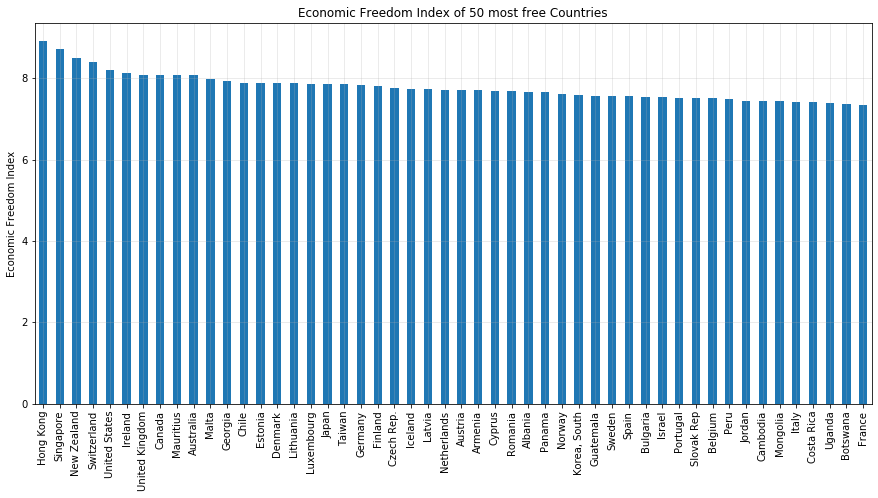

In [21]:
fig, ax = plt.subplots(figsize=(15,7))

ec_fr.groupby('Country').agg({'EFI':'mean'}).sort_values(by='EFI', ascending=False).iloc[0:50].plot.bar(ax=ax, legend=False)
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('Economic Freedom Index')
_ = ax.set_xlabel('')
_ = ax.set_title('Economic Freedom Index of 50 most free Countries')

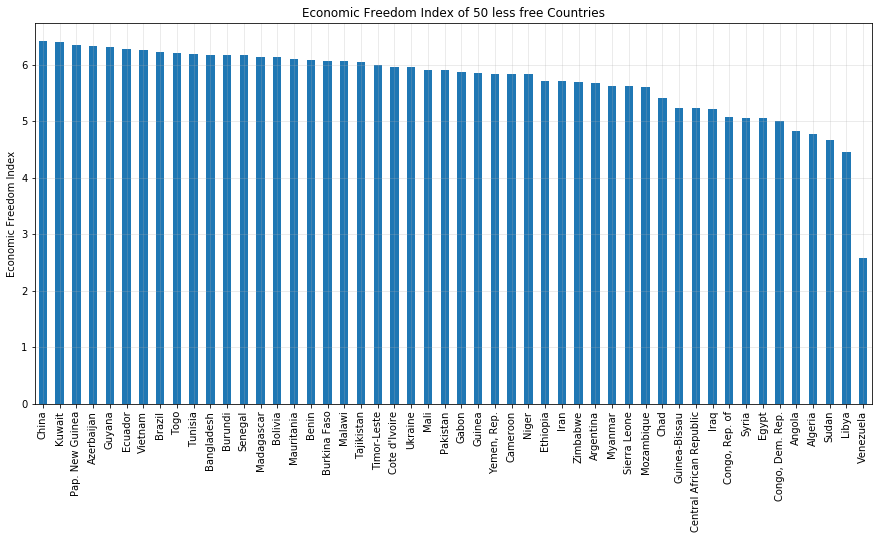

In [22]:
fig, ax = plt.subplots(figsize=(15,7))

ec_fr.groupby('Country').agg({'EFI':'mean'}).sort_values(by='EFI').iloc[0:50].plot.bar(ax=ax, legend=False)
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('Economic Freedom Index')
_ = ax.set_xlabel('')
_ = ax.set_title('Economic Freedom Index of 50 less free Countries')
_ = plt.gca().invert_xaxis()

In [23]:
oecd = ['Australia',
        'Brazil',
        'Canada',
        'China', 'Germany', 
        'Denmark', 'Spain',
        'France',
        'United Kingdom',
        'United States',
        'India', 'Iceland',
        'Ireland',
        'Italy', 'Japan',
        'Korea, Rep.',
        'Sweden']

In [24]:
oecd_gini = gini[gini['Country Name'].isin(oecd)].drop('Indicator Code', axis=1)

for col in oecd_gini.iloc[:, 2:].columns:
    oecd_gini[col] = oecd_gini[col].apply(lambda x: np.nan if x == 'nan' else float(x))

years = [year.split('.')[0] for year in oecd_gini.set_index('Country Name').iloc[:, 23:].columns]
to_plot = oecd_gini.set_index('Country Name').iloc[:, 23:]

for y, name in zip(years, oecd_gini.set_index('Country Name').iloc[:, 23:].columns):
    to_plot.rename({name:y}, axis=1, inplace=True)
    
to_plot = to_plot.T
    
to_plot = nan_int(to_plot, int_vars = to_plot.columns)

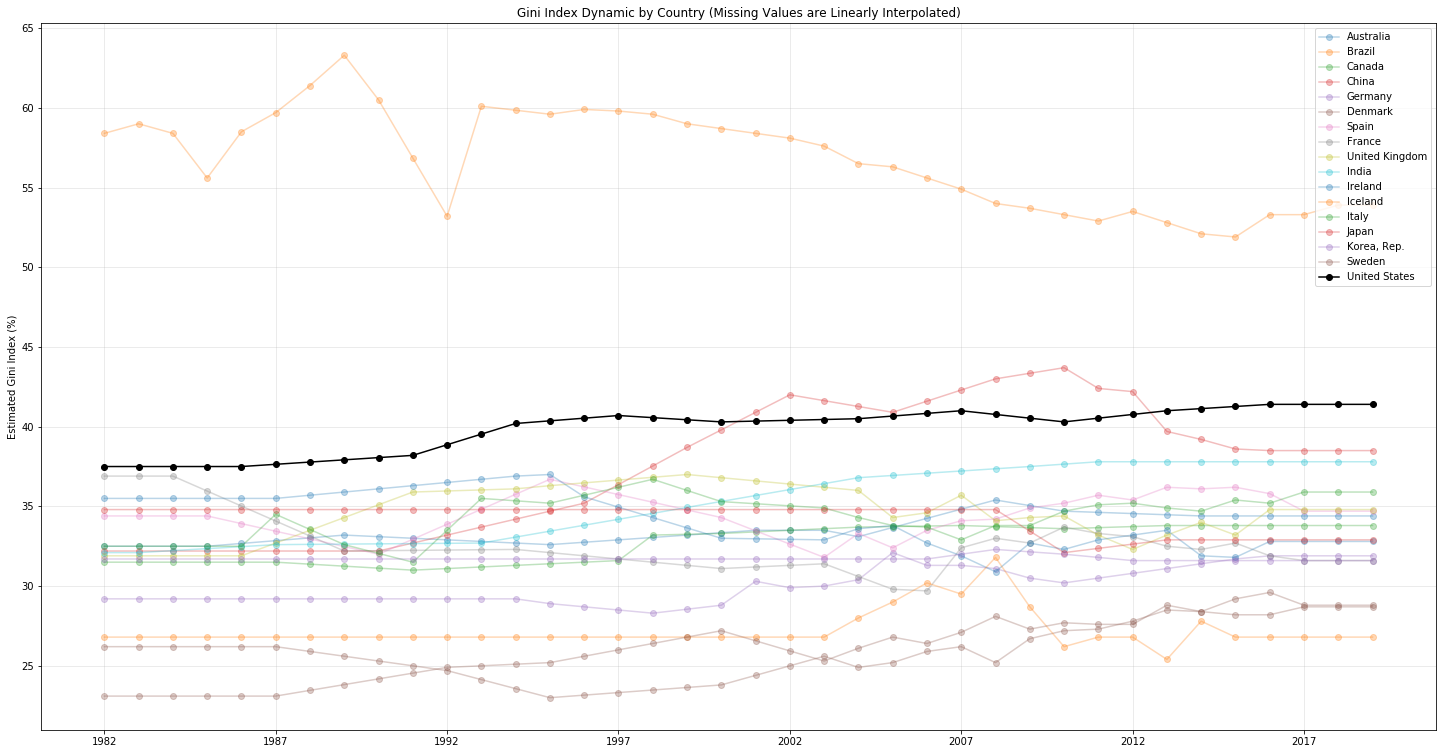

In [113]:
fig, ax = plt.subplots(figsize=(25,13))

country = 'United States' # change the country to change the darkest dynamic
to_plot.drop(country, axis=1).plot(ax=ax, marker='o', alpha=.3)
to_plot[country].plot(ax=ax, marker='o', c='k', label=str(country))
_ = ax.set_title('Gini Index Dynamic by Country (Missing Values are Linearly Interpolated)')
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('Estimated Gini Index (%)')
_ = ax.legend()

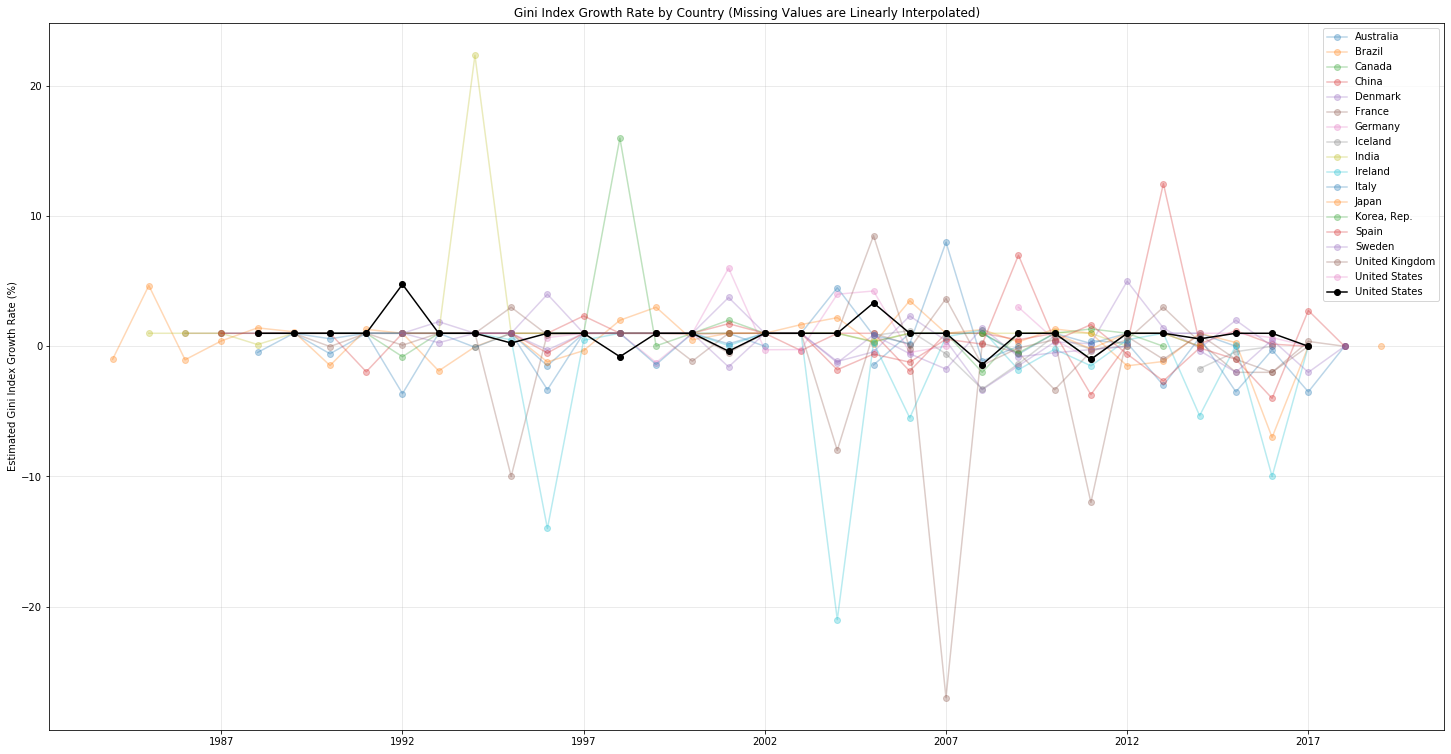

In [111]:
fig, ax = plt.subplots(figsize=(25,13))

country = 'United States'
to_plot.drop(country, axis=1).diff().div(to_plot.shift(1).diff()).plot(ax=ax, marker='o', alpha=.3)
to_plot[country].diff().div(to_plot[country].shift(1).diff()).plot(ax=ax, marker='o', c='k', label=str(country))
_ = ax.set_title('Gini Index Growth Rate by Country (Missing Values are Linearly Interpolated)')
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('Estimated Gini Index Growth Rate (%)')
_ = ax.legend()

As we can see from the plots, the storytelling about the immense rise in income inequality is not that accurate. Surely there are some countries in which this dynamic is glaring, with United States, United Kingdom, China and India being the main examples but, in general, we can see a substantial stationarity in the selected time series. Looking at this dynamics, we should keep in mind that the Gini index is non-paretian, in the sense that is sub-optimal: it captures only concentration in income distribution, but doesn't say anything about the life condition of the population. In fact, considering data from China and India, even if they are associated with a significant increase in inequality, the life conditions of poorest sizes of the population are now incredibly better than the 80's, when the quote of people living in extreme poverty was way bigger.

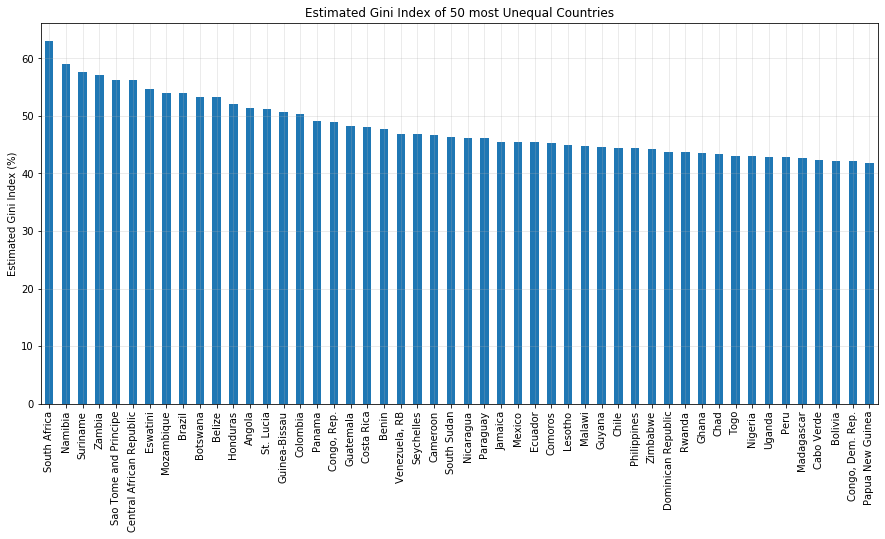

In [26]:
fig, ax = plt.subplots(figsize=(15,7))

last_gini.groupby('Country').agg({'Last Disposable Gini':'mean'}) \
                            .sort_values(by='Last Disposable Gini', ascending=False).iloc[0:50].plot.bar(ax=ax, legend=False)
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('Estimated Gini Index (%)')
_ = ax.set_xlabel('')
_ = ax.set_title('Estimated Gini Index of 50 most Unequal Countries')

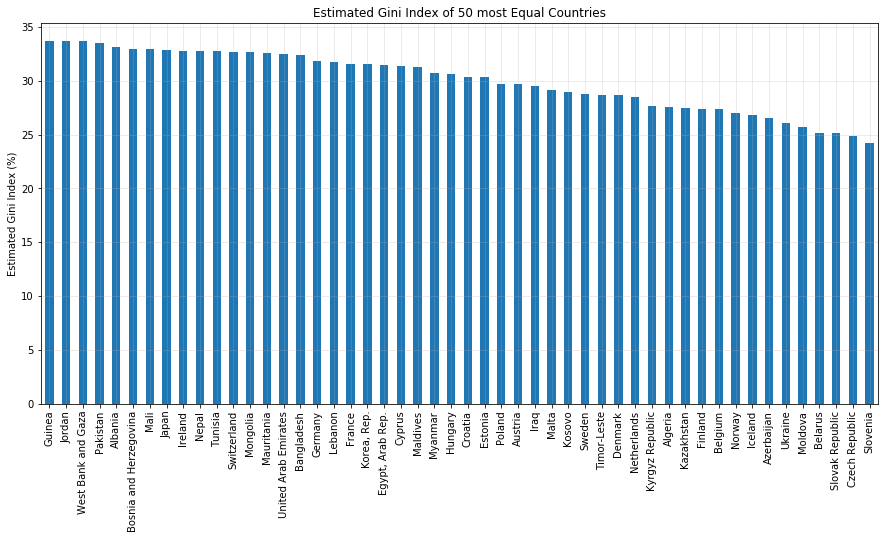

In [27]:
fig, ax = plt.subplots(figsize=(15,7))

last_gini.groupby('Country').agg({'Last Disposable Gini':'mean'}) \
                            .sort_values(by='Last Disposable Gini').iloc[0:50].plot.bar(ax=ax, legend=False)
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('Estimated Gini Index (%)')
_ = ax.set_xlabel('')
_ = ax.set_title('Estimated Gini Index of 50 most Equal Countries')
_ = plt.gca().invert_xaxis()

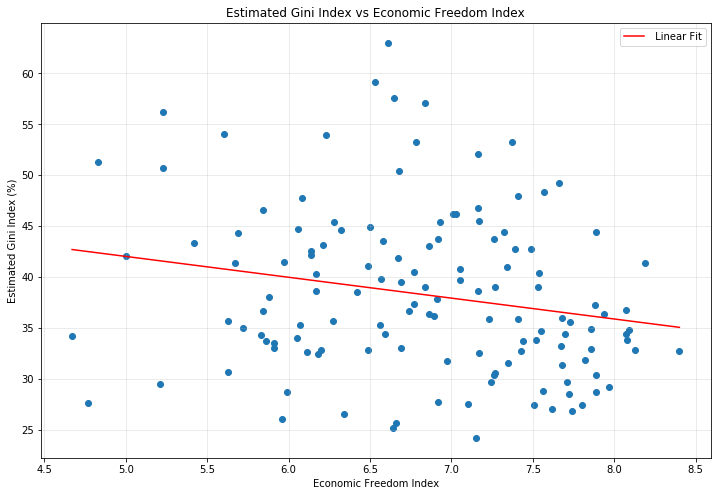

In [28]:
fig, ax = plt.subplots(figsize=(12,8))

sf = scatter_fit(ec_gini['EFI'], ec_gini['Last Disposable Gini'], ax=ax)
_ = sf[1].set_title('Estimated Gini Index vs Economic Freedom Index')
_ = sf[1].set_xlabel('Economic Freedom Index')
_ = sf[1].set_ylabel('Estimated Gini Index (%)')

In [29]:
# clustering (k-means)

ec_gini_km = ec_gini.copy().loc[:, ['EFI','Last Disposable Gini']]

sd = StandardScaler()

a_sl = []
s_sl = []
pred = []
for n_clust in range(2,6):
    kmeans = KMeans(n_clusters=n_clust, random_state=10)
    
    ppl = Pipeline([
    ('sd', sd),
    ('kmeans', kmeans)
    ])
    
    kmpred = ppl.fit_predict(ec_gini_km)
    a_sl.append(silhouette_score(ec_gini_km, kmpred))
    s_sl.append(silhouette_samples(ec_gini_km, kmpred))
    pred.append(ppl.fit_predict(ec_gini_km))

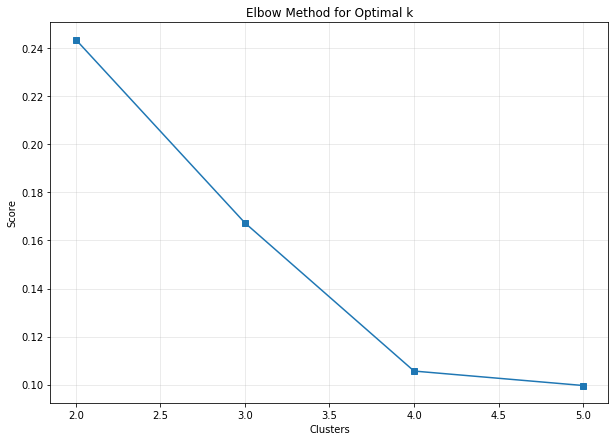

In [30]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(range(2,6), a_sl, marker = 's')
_ = ax.grid(alpha=.3)
_ = ax.set_title('Elbow Method for Optimal k')
_ = ax.set_xlabel('Clusters')
_ = ax.set_ylabel('Score')

In [31]:
ec_gini['Clusters'] = pred[0]
ec_gini['Clusters_2'] = pred[1]
ec_gini['Clusters_3'] = pred[2]
ec_gini['Clusters_4'] = pred[3]

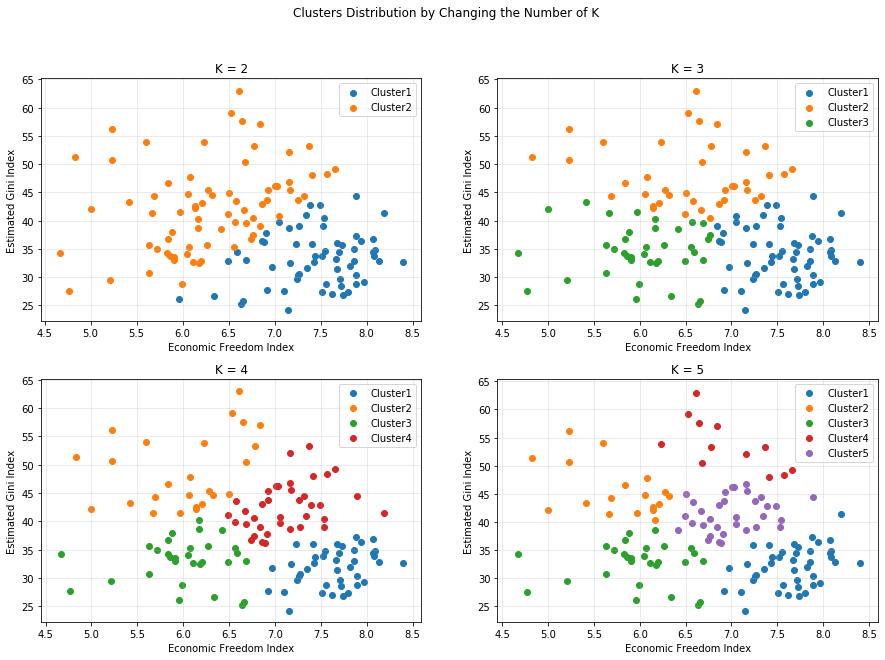

In [32]:
fig, ax = plt.subplots(2,2, figsize=(15,10))

x = ax.flatten()
clust = {'Clusters':[0,1], 'Clusters_2':[0,1,2], 'Clusters_3':[0,1,2,3], 'Clusters_4':[0,1,2,3,4]}

for n, (cl, vals) in enumerate(zip(clust.keys(), clust.values())):
    for n_cl in vals:
        _ = x[n].scatter(ec_gini[ec_gini[cl] == n_cl]['EFI'], 
                         ec_gini[ec_gini[cl] == n_cl]['Last Disposable Gini'], label='Cluster'+str(n_cl+1))
    _ = x[n].grid(alpha=.3)
    _ = x[n].legend()
    _ = x[n].set_xlabel('Economic Freedom Index')
    _ = x[n].set_ylabel('Estimated Gini Index')
    _ = x[n].set_title('K = '+str(len(vals)))
    
_ = fig.suptitle('Clusters Distribution by Changing the Number of K')
_ = fig.subplots_adjust(hspace=.24)

Let's see which countries are "virtuos" and which are "bad". For semplicity, and focusing more on intuition than statistical rigorousness, let's use the k=4 division and let's consider the ones in the orange cluster as bad and the ones in the blue clusters as virtuous. Other countries will be considered as "intermediate", in the sense that they might have low Gini but low freedom or high Gini but high fredoom.

In [33]:
ec_gini['Score'] = ec_gini['Clusters_3'].apply(lambda x: 'Bad' if x == 1 
                                               else 'Intermediate' if x == 2
                                               else 'Intermediate' if x == 3
                                               else 'Virtuous' if x == 0 else x)

In [34]:
efi_cl = []

for sc in ec_gini['Score'].sort_values().unique():
    efi_cl.append(ec_gini[ec_gini['Score'] == sc].groupby('Country') \
          .agg({'EFI':'mean', 'Last Disposable Gini':'mean'}).sort_values(by='Last Disposable Gini', ascending=False).reset_index().EFI)

Note:These classifications only consider inequality and economic fredoom, not life quality or gdp.


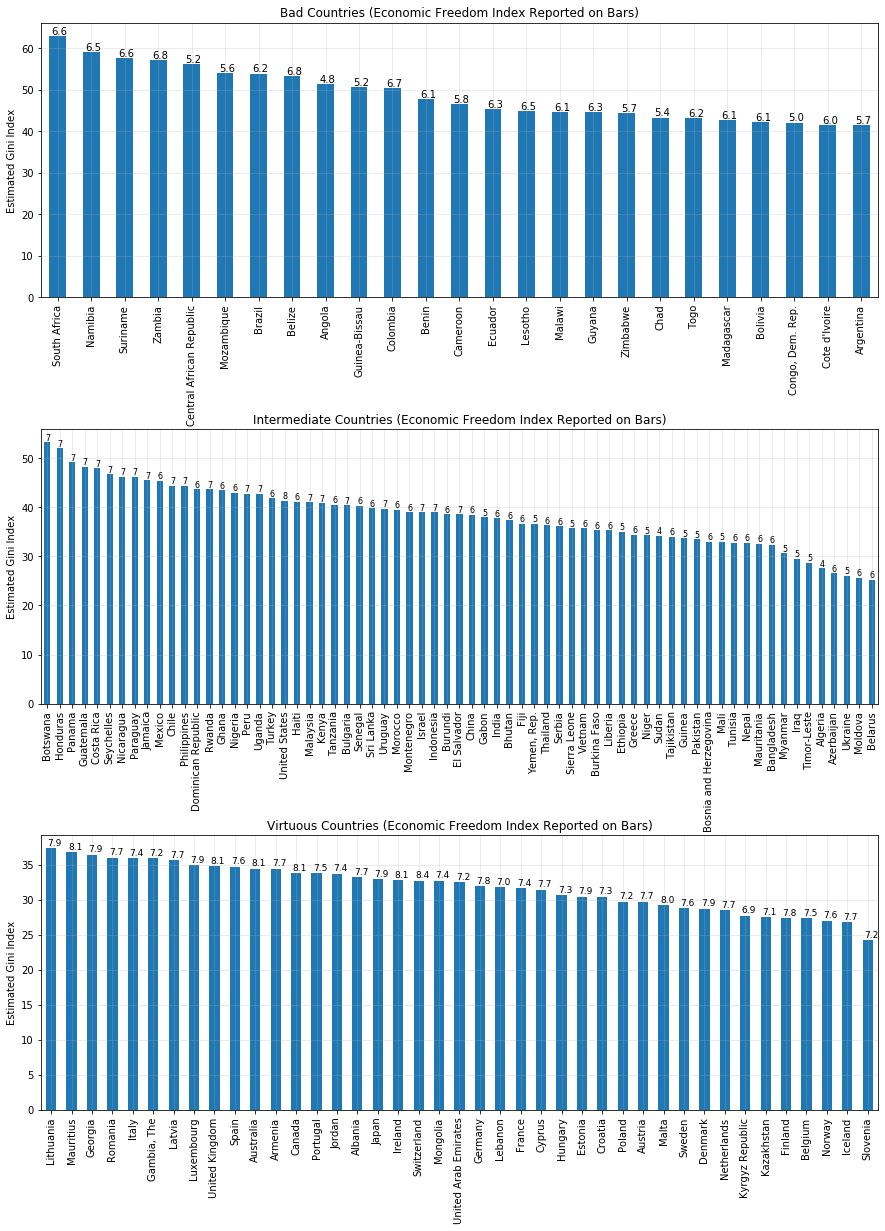

In [35]:
fig, ax = plt.subplots(3,1, figsize=(15,20))

x = ax.flatten()
for n, sc in enumerate(ec_gini['Score'].sort_values().unique()):
    to_pl_sc = ec_gini[ec_gini['Score'] == sc].groupby('Country') \
                                              .agg({'Last Disposable Gini':'mean'}).sort_values(by='Last Disposable Gini', ascending=False)
    to_pl_sc.plot.bar(legend=False, ax=x[n])
    _ = x[n].set_xlabel('')
    _ = x[n].set_title(sc+' Countries (Economic Freedom Index Reported on Bars)')
    _ = x[n].set_ylabel('Estimated Gini Index')
    _ = x[n].grid(alpha=.3)
    
    for num, i in enumerate(x[n].patches): # adding EFI on each bar
        
        if n == 0:
            _ = x[n].text(i.get_x()+i.get_width()/7, i.get_height()+.4, str(round(efi_cl[n][num],1)))
            
        elif n == 1:
            _ = x[n].text(i.get_x()+i.get_width()/7, i.get_height()+.4, str(int(efi_cl[n][num])), fontsize=8)
            
        elif n == 2:
            _ = x[n].text(i.get_x()+i.get_width()/7, i.get_height()+.4, str(round(efi_cl[n][num],1)), fontsize=9)
        
_ = fig.subplots_adjust(hspace=.48)

print('\033[1m'+'Note:'+'\033[0m'+'These classifications only consider inequality and economic freedom, not life quality or gdp.')

In [36]:
ec_gini = ec_gini.drop(['Clusters', 'Clusters_2', 'Clusters_3', 'Clusters_4', 'Score'], axis=1)
ec_gini['tmitr_data'] = ec_gini['tmitr_data'].apply(lambda x: str(x).replace('-','.'))

In [37]:
feat_degree = {'gc_data':1,
               'ts_data':2,
               'tmitr_data':1,
               'Size of Government':1,
               'State ownership of assets':1,
               'inf_data':1,
               'Capital controls':1,
               'Credit market regulations':1,
               'Centralized collective bargaining':2,
               'Hiring regulations and minimum wage':1,
               'Labor market regulations':1,
               'Business regulations':1}

Note: Indexes are higher when regulation in that sector is low (not valid for values reported as _data)


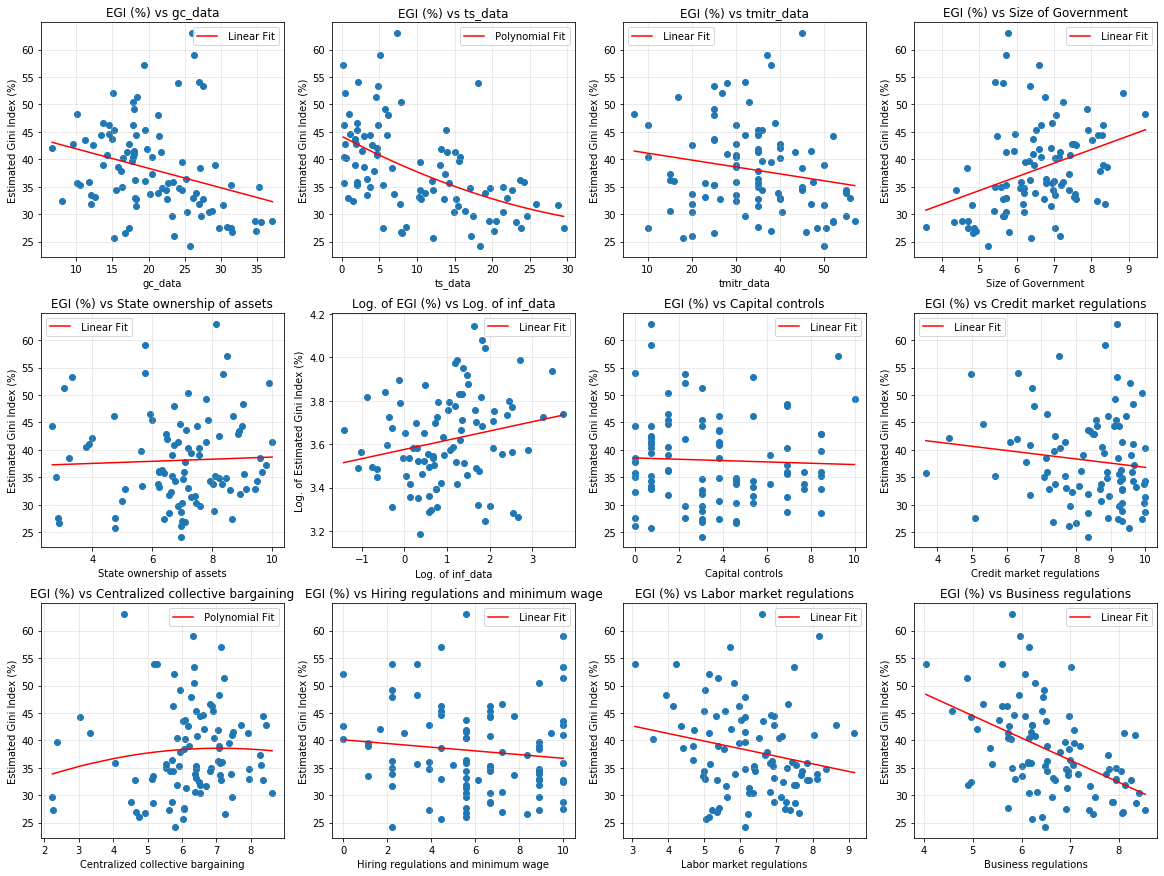

In [38]:
ec_gini_nona = ec_gini.dropna()

fig, ax = plt.subplots(3,4, figsize=(20,15))

x = ax.flatten()

for n, (var, deg) in enumerate(zip(feat_degree.keys(), feat_degree.values())):
    if var == 'inf_data':
        sf = scatter_fit(np.log(ec_gini_nona[var].astype('float')), np.log(ec_gini_nona['Last Disposable Gini']), ax=x[n], degree=deg)
        _ = x[n].set_ylabel('Log. of Estimated Gini Index (%)')
        _ = x[n].set_xlabel('Log. of inf_data')
        _ = x[n].set_title('Log. of EGI (%) vs Log. of '+str(var))
    else:
        sf = scatter_fit(ec_gini_nona[var].astype('float'), ec_gini_nona['Last Disposable Gini'], ax=x[n], degree=deg)
        _ = x[n].set_ylabel('Estimated Gini Index (%)')
        _ = x[n].set_xlabel(var)
        _ = x[n].set_title('EGI (%) vs '+str(var))
    
_ = fig.subplots_adjust(hspace=.24)

print('\033[1m'+'Note:'+'\033[0m'+' Indexes are higher when regulation in that sector is low (not valid for values reported as _data)')

So, by looking at these plots, we can say that economic freedom per se has nothing to do with inequality in income distribution. In fact, in general, the opposite is true: the first scatterplot shows a little negative correlation between the estimated Gini index for a selected country and it's level of economic freedom. Obviously this has to be verified using statistical modeling and/or machine learning, but it gives us a good preliminary intuition.

Going more deeply, we can say that if we want to mantain a low level of income inequality, we should keep the market as free as possible and inflation as low as possible, but we should integrate these policies with a relevant quote of tranfers for social security and welfare in general.

### 3. Visualization - Gini / GDP ###

In [39]:
oecd_gdp = gdp[gdp['Country'].isin(oecd)].drop('ISO_Code', axis=1)

for col in oecd_gdp.iloc[:, 2:].columns:
    oecd_gdp[col] = oecd_gdp[col].apply(lambda x: np.nan if x == 'nan' else float(x))

to_plot_gdp = oecd_gdp.set_index('Country').iloc[:, 32:]
    
to_plot_gdp = to_plot_gdp.T
    
to_plot_gdp = nan_int(to_plot_gdp, int_vars = to_plot_gdp.columns)

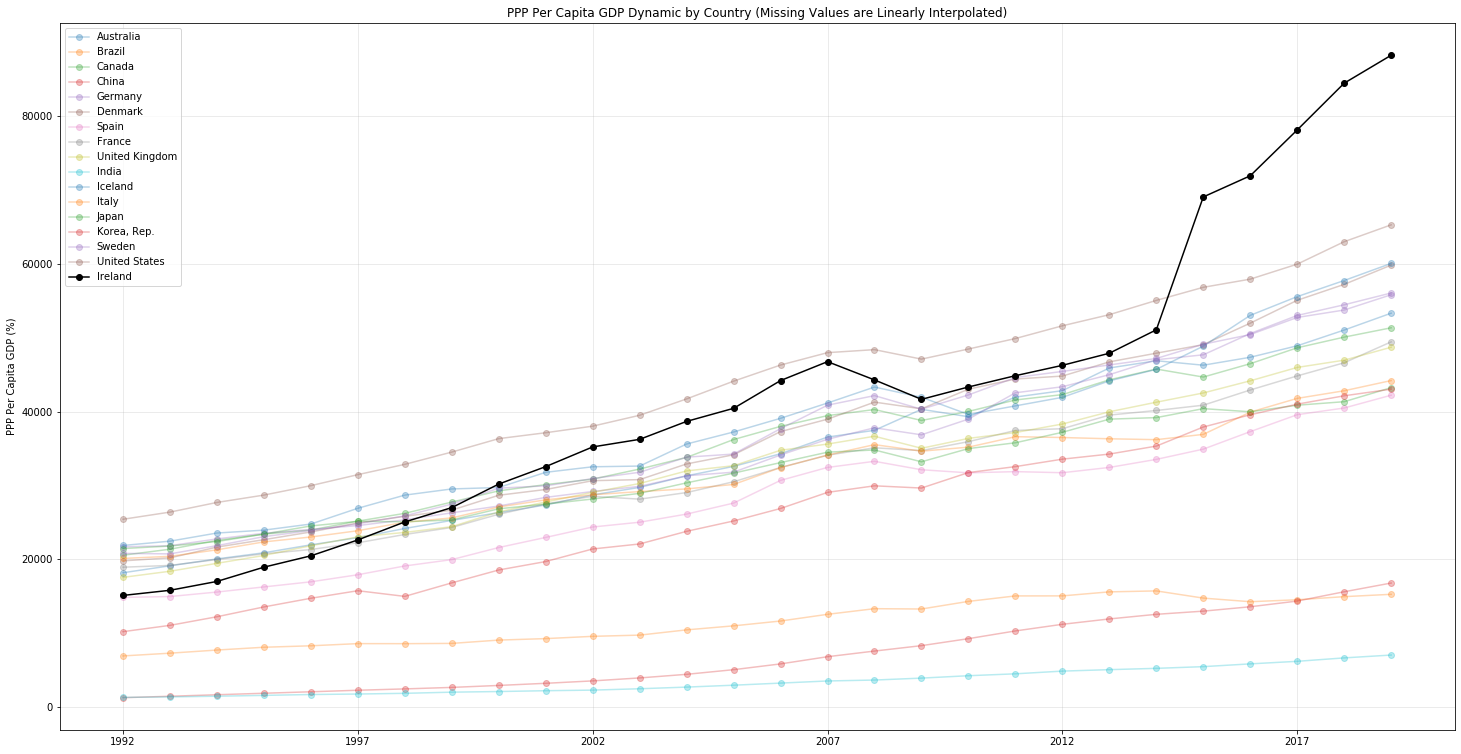

In [40]:
fig, ax = plt.subplots(figsize=(25,13))

country = 'Ireland' # change the country to change the darkest dynamic
to_plot_gdp.drop(country, axis=1).plot(ax=ax, marker='o', alpha=.3)
to_plot_gdp[country].plot(ax=ax, marker='o', alpha=1, c='k', label=country)
_ = ax.set_title('PPP Per Capita GDP Dynamic by Country (Missing Values are Linearly Interpolated)')
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('PPP Per Capita GDP')
_ = ax.legend()

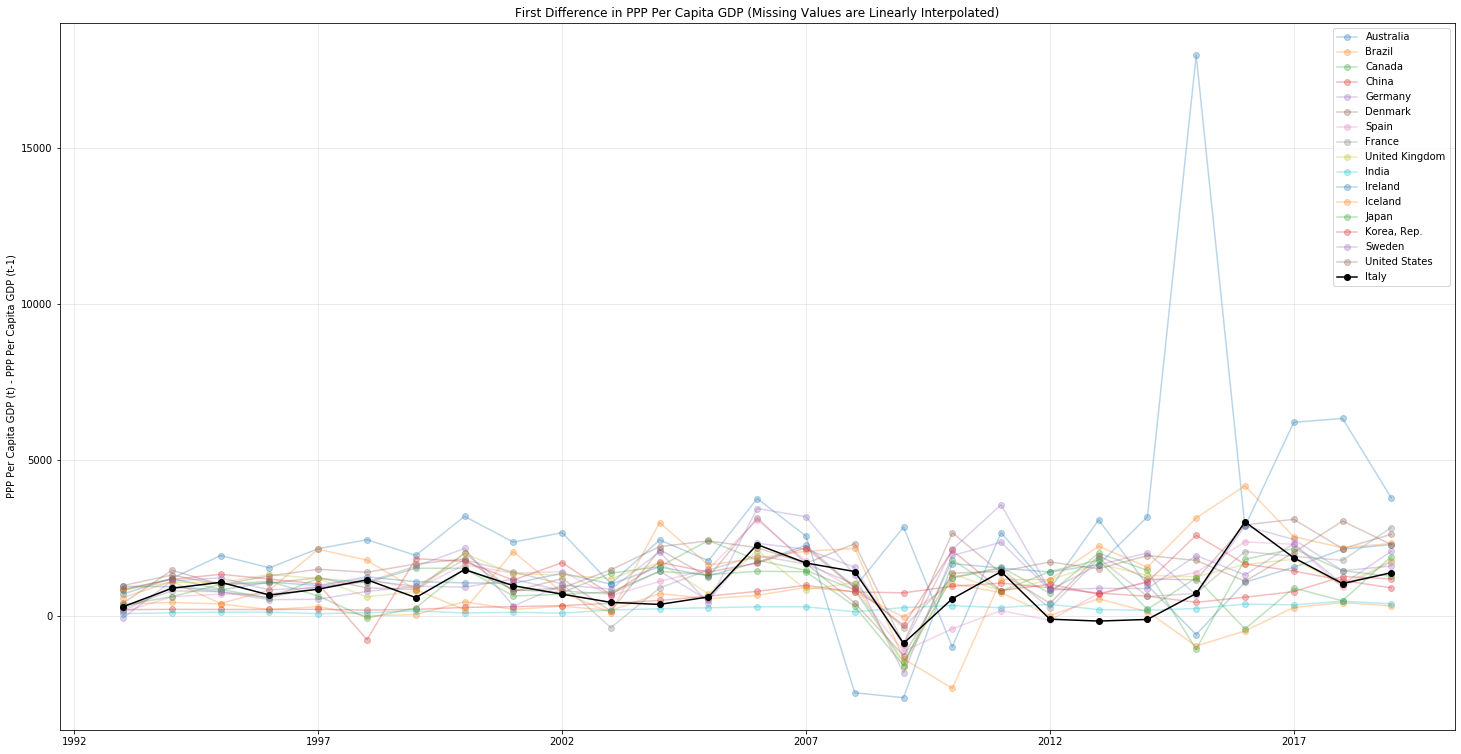

In [89]:
# plotting first derivatives

fig, ax = plt.subplots(figsize=(25,13))

country = 'Italy' # change the country to change the darkest dynamic
to_plot_gdp.drop(country, axis=1).diff().plot(ax=ax, marker='o', alpha=.3)
to_plot_gdp[country].diff().plot(ax=ax, marker='o', alpha=1, c='k', label=country) 
_ = ax.set_title('First Difference in PPP Per Capita GDP (Missing Values are Linearly Interpolated)')
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('PPP Per Capita GDP (t) - PPP Per Capita GDP (t-1)')
_ = ax.legend()

Note: Mean is highly influenced by outliers (expecially Brazil)


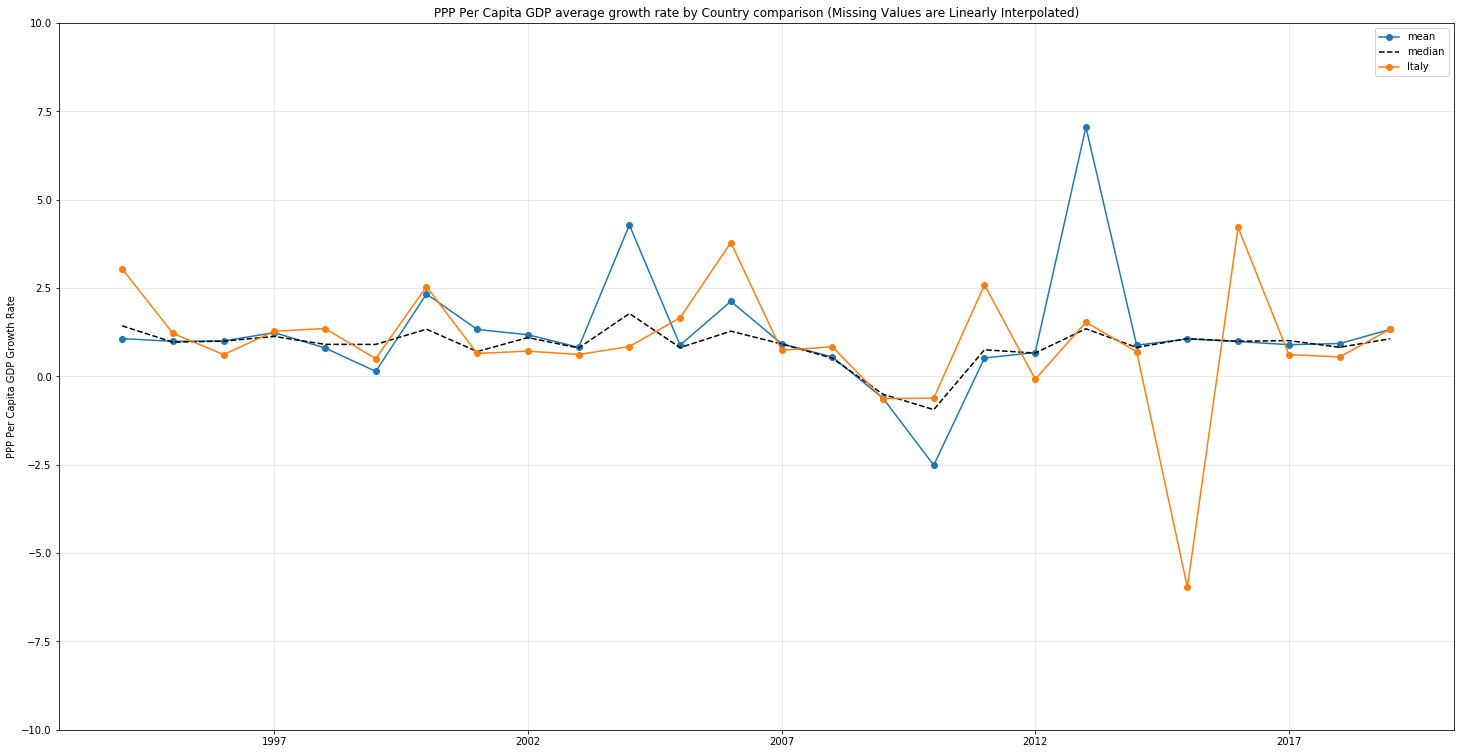

In [95]:
# Comparison between OCSE average growth rate with selected country

fig, ax = plt.subplots(figsize=(25,13))

country = 'Italy' # here you can change the country you want to compare
to_plot_gdp.drop(country, axis=1).diff().div(to_plot_gdp.drop(country, axis=1).shift(1).diff()) \
                                                                                       .mean(axis=1).plot(ax=ax, marker='o', label='mean')
to_plot_gdp.drop(country, axis=1).diff().div(to_plot_gdp.drop(country, axis=1).shift(1).diff()) \
                                                        .median(axis=1).plot(ax=ax, linestyle='--', c='k', label='median')
to_plot_gdp[country].diff().div(to_plot_gdp[country].shift(1).diff()).plot(ax=ax, marker='o', alpha=1, label=country) 
_ = ax.set_title('PPP Per Capita GDP average growth rate by Country comparison (Missing Values are Linearly Interpolated)')
_ = ax.grid(alpha=.3)
_ = ax.set_ylabel('PPP Per Capita GDP Growth Rate')
_ = ax.legend()
_ = ax.set_ylim(-10,10)

print('\033[1m'+'Note:'+'\033[0m'+' Mean is highly influenced by outliers (expecially Brazil)')